In [2]:
# Importing all the required libraries

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch import optim
from torchvision import transforms
from torch.autograd import Variable

from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
from torch.autograd import Variable

from ipykernel import kernelapp as app
from tqdm.autonotebook import tqdm

from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
cmap = plt.cm.jet
from matplotlib.pyplot import imshow

from datetime import datetime

import time
import cv2
import pandas as pd
import numpy as np
import os
import random
import glob
import pickle
import csv

from sklearn.metrics import accuracy_score

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import backend as tf_keras_backend
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

tf_keras_backend.set_image_data_format('channels_last')
tf_keras_backend.image_data_format()

import warnings
warnings.filterwarnings('ignore')


## Preprocessing Images to same dimensions

In [4]:
def padding(image, old_width, old_height, new_width, new_height):
    h1, h2 = int((new_height - old_height) / 2), int((new_height - old_height) / 2) + old_height
    w1, w2 = int((new_width - old_width) / 2), int((new_width - old_width) / 2) + old_width
    image_pad = np.ones([new_height, new_width, 3]) * 255
    image_pad[h1:h2, w1:w2, :] = image
    return image_pad


def set_size(image, target_w, target_h):
    h, w = image.shape[:2]
    if w < target_w and h < target_h:
        image = padding(image, w, h, target_w, target_h)
    elif w >= target_w and h < target_h:
        new_width = target_w
        new_height = int(h * new_width / w)
        new_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)
        image = padding(new_image, new_width, new_height, target_w, target_h)
    elif w < target_w and h >= target_h:
        new_height = target_h
        new_width = int(w * new_height / h)
        new_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)
        image = padding(new_image, new_width, new_height, target_w, target_h)
    else:
        """w>=target_w and h>=target_h """
        ratio = max(w / target_w, h / target_h)
        new_width = max(min(target_w, int(w / ratio)), 1)
        new_height = max(min(target_h, int(h / ratio)), 1)
        new_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)
        image = padding(new_image, new_width, new_height, target_w, target_h)
    return image


def preprocess_image (path, image_w, image_h):
    """ Pre-processing image for predicting """
    image = cv2.imread(path)
    image = set_size(image, image_w, image_h)

    image = np.clip(image, 0, 255)
    image = np.uint8(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    image = image.astype(np.float32)
    image /= 255
    return image

### Data Paths

In [18]:
# Getting current working directory to get back to this directory easily
cwd=os.getcwd()
images_path='C:\\Users\\jimev\\Desktop\\Project_Data\\Words\\'
labels_path='C:\\Users\\jimev\\Desktop\\Project_Data\\Words\\words.txt'

In [19]:
# Total Classes in the data
classes = ' !"#&\'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'

 - Our labels are different words, so we need to bring them a number format. 
 - Above are all the characters that can be present in a word. 
 - So we have created an array of integers where these integers are indexes in this classes variable

In [20]:
def getLabelArray(label):
    '''
    Input: String/Word
    Returns: Gives us an Array containing indexes of each character in the input
    '''
    return list(map(lambda x: classes.index(x), label))

def getActualLabel(labels):
    '''
    Input: Array which has the indexes of the string/word
    Returns: String/Word
    '''
    return ''.join(list(map(lambda x: classes[int(x)], labels)))

In [21]:
# Example
getLabelArray('John')

[36, 67, 60, 66]

In [22]:
getActualLabel([36, 67, 60, 66])

'John'

Function to get metadata

In [23]:
def getInfo(filepath):    
    '''
    Input: Path of the text file containing info of the image path and their labels
    Output: A array containing data information:
    Example Output:
    [[Image1path, label1], [Image2path, label2],...]  
    '''
    
    fp=open(filepath, 'r')
    data=[]
    #len16=[]
    #len0=[]
    bad_images=[]
    for item in fp:
        if item[0]=='#':
            continue
        #print (item)
        items=item.strip().split(' ')

        #print(items)
        filename=items[0]
        filename=filename.split('-')
        filepath=images_path+filename[0]+'/'+filename[0]+'-'+filename[1]+'/'+ \
            filename[0]+'-'+filename[1]+'-'+filename[2]+'-'+filename[3]+'.png'


        if not os.path.getsize(filepath):
            bad_images.append(filename[0]+'-'+filename[1]+'-'+filename[2]+'-'+filename[3]+'.png')
            continue
        
        label=' '.join(elem for elem in items[8:])
        # Picking images with less than 16 characters
        if len(label)>16:
            #print('Length greater than 16 found')
            #len16.append([filepath, label])
            continue
        # Eliminating images which doesnt have a label at all
        if len(label)<=0 or label==None:
            continue
            #print('None Value found')
            #len0.append([filepath, label])
        
        data.append([filepath, label])
    fp.close()
    return data

In [24]:
# Complete Data Info
data=getInfo(labels_path)

## Sample Data before Preprocessing

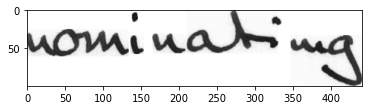

nominating 




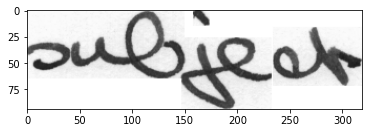

subject 




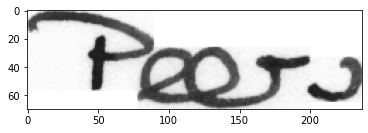

Peers 




In [25]:
random.seed(123)
count=0
while count!=3:
    value=random.randint(1, 100)
    image_info=data[value]
    #print(line)
    path=image_info[0]
    #print(path)
    image = cv2.imread(path)
    imageplot = plt.imshow(image)
    plt.show()
    #print(line)
    label=image_info[1]#getActualText(np.array(line[1]))
    print(label, '\n\n')
    count+=1
        

## Sample Data after Preprocessing

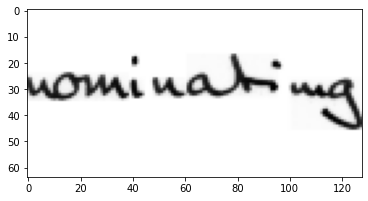

nominating 




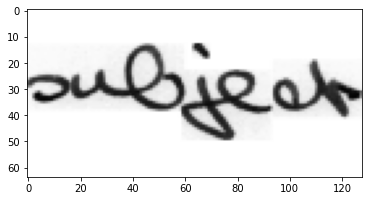

subject 




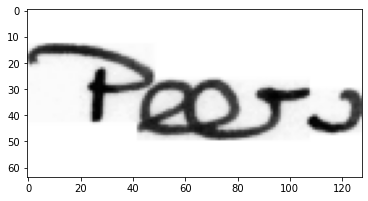

Peers 




In [26]:
random.seed(123)
count=0
while count!=3:
    value=random.randint(1, 100)
    image_info=data[value]
    #print(line)
    path=image_info[0]
    #print(path)
    image=preprocess_image(path, 128, 64)
    
    plt.imsave('temp.png', image, cmap='gray')
    image = cv2.imread('temp.png')
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #image = image.convert('RGB')
    
    #image = mpimage.imread(path)
    imageplot = plt.imshow(image)
    plt.show()
    #print(line)
    label=image_info[1]#getActualText(np.array(line[1]))
    print(label, '\n\n')
    count+=1
    #os.remove('temp.png')
        

#### Train, Test, Validation Split

In [27]:

train_paths=data[:int((0.7)*len(data))]
test_paths=data[int((0.8)*len(data)):int((0.90)*len(data))]
val_paths=data[int((0.95)*len(data)):]
len(train_paths), len(val_paths), len(test_paths)

(80710, 5766, 11530)

In [28]:
## Customized Dataloader to input Data

class MyDataLoader(Dataset):
    
    def __init__(self, data_file, transform=None):
        
        self.data_file = data_file
        self.transform = transform
        self.imagepaths=[]
        self.labels=[]
        
        for i, (image_path, label) in enumerate(data_file):
            self.imagepaths.append(image_path)
            self.labels.append(label)
    
    def __len__(self):
        return len(self.imagepaths)
    

    def __getitem__(self, idx):
        imagepath=self.imagepaths[idx]
        label=self.labels[idx]
        #label=getLabelArray(label)
        #label=list(label)
        #label=ASCIISentence(label)
        image=preprocess_image(imagepath, 128, 128)
        plt.imsave('temp.png', image, cmap=cmap)
        image = Image.open('temp.png')
        image = image.convert('RGB')
        os.remove('temp.png')
        
        #image = np.swapaxes(image, 2, 0)
        #image = np.expand_dims(image, axis=-1)  # Equivalent to x[:,:,np.newaxis]
        #image=Image.open(imagepath)
        #image=preprocess(cv2.imread(imagepath, cv2.IMREAD_GRAYSCALE), (128,32))
        #image = image.convert('RGB')
        
        if self.transform is not None:
            image=self.transform(image)
        #l=[]
        #label=(getLabelArray(label))
        #l.append(label)
        #print(l)
        #break
        return image, label

In [29]:
# Applying transformations on the data
transformations = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [30]:
# Data Preparation
train_set=MyDataLoader(train_paths, transform=transformations)
test_set=MyDataLoader(test_paths, transform=transformations)
# Data Loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size= 32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size= 32, shuffle=True)

#### Few more sample images after preprocessing from the data

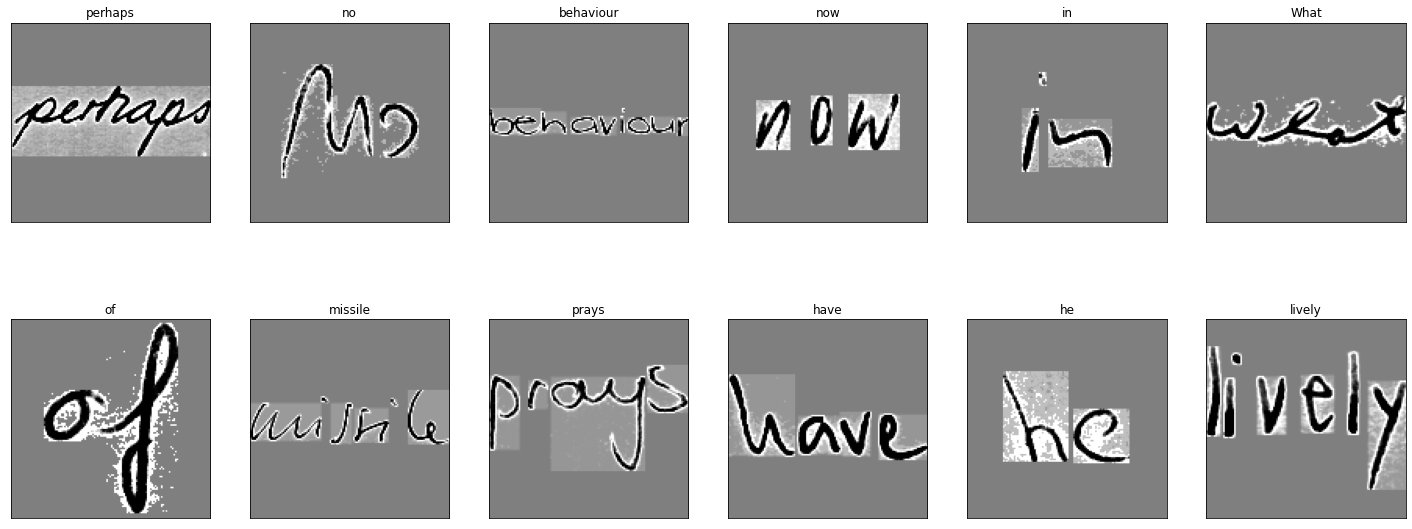

In [31]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
# plot the images in the batch, along with the corresponding labels
### print(dataiter.next())
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 10))
plot_size=12
for idx in np.arange(12):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    #images[idx]=np.swapaxes(images[idx], 2, 0)
    ax.imshow(images[idx][0], cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    #print(labels[idx])
    ax.set_title(labels[idx])
    

In [32]:
def moveTo(obj, device):
    '''
    Function moved the obj to the availble device--> either cpu or cuda
    obj: object
    device: cpu or gpu
    '''
    if isinstance(obj, tuple):
        return tuple([moveTo(x, device) for x in obj])
    elif isinstance(obj, list):
        return [moveTo(x, device) for x in obj]
    elif isinstance(obj, torch.Tensor):
        return obj.to(device)
    else:
        return x

In [33]:
def train_network(model, loss_func, train_loader, val_loader=None, score_funcs=None, 
                         epochs=10, device="cpu", checkpoint_file=None, 
                         lr_schedule=None, optimizer=None, disable_tqdm=False
                        ):
    """Train simple neural networks
    
    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs. 
    val_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training
    
    """
    if score_funcs == None:
        score_funcs = {}#Empty set 
    
    to_track = ["epoch", "total time", "train loss"]
    if val_loader is not None:
        to_track.append("val loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if val_loader is not None:
            to_track.append("val " + eval_score )
        
    total_train_time = 0 #How long have we spent in the training loop? 
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []

        
    if optimizer == None:
        #The AdamW optimizer is a good default optimizer
        optimizer = torch.optim.AdamW(model.parameters())
        del_opt = True
    else:
        del_opt = False

    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch", disable=disable_tqdm):
    
        model = model.train()#Put our model in training mode
        running_loss = 0.0
        
        y_true = []
        y_pred = []

        start = time.time()
        for inputs, labels in tqdm(train_loader, desc="Train Batch", leave=False, disable=disable_tqdm):
      
            #Move the batch to the device we are using. 
            inputs = moveTo(inputs, device)
            labels = Variable(torch.IntTensor([cdict[c] for c in ''.join(labels)]))
            label_lens = torch.IntTensor([len(t) for t in transcr])
            labels = moveTo(labels, device)
            
            #batch_size = labels.shape[0]
            batch_size=len(label_lens)

            # PyTorch stores gradients in a mutable data structure. So we need to set it to a clean state before we use it. 
            #Otherwise, it will have old information from a previous iteration
            optimizer.zero_grad()

            y_hat = model(inputs) #this just computed f_Θ(x(i))

            # Compute loss.
            loss = loss_func(y_hat, labels)

            loss.backward()# ∇_Θ just got computed by this one call!

            #Now we just need to update all the parameters! 
            optimizer.step()# Θ_{k+1} = Θ_k − η * ∇_Θ ℓ(y_hat, y)

            #Now we are just grabbing some information we would like to have
            running_loss += loss.item() * batch_size
            
            if len(score_funcs) > 0:
                #moving labels & predictions back to CPU for computing / storing predictions
                labels = labels.detach().cpu().numpy()
                y_hat = y_hat.detach().cpu().numpy()
                for i in range(batch_size):
                    y_true.append(labels[i])
                    y_pred.append(y_hat[i,:])
        #end training epoch
        end = time.time()
        total_train_time += (end-start)
        
        results["epoch"].append( epoch )
        results["total time"].append( total_train_time )
        results["train loss"].append( running_loss )
        
        y_pred = np.asarray(y_pred)
        
        if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
            y_pred = np.argmax(y_pred, axis=1)
            
        for name, score_func in score_funcs.items():
            results["train " + name].append( score_func(y_true, y_pred) )
      
        if val_loader is None:
            pass
        else:#Lets find out validation performance as we go!
            model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!

            y_true = []
            y_pred = []
            
            val_running_loss = 0.0

            for inputs, labels in val_loader:
        
                #Move the batch to the device we are using. 
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                batch_size = labels.shape[0]
        
                y_hat = model(inputs)
            
                loss = loss_func(y_hat, labels)
                
                #Now we are just grabbing some information we would like to have
                val_running_loss += loss.item() * batch_size

                if len(score_funcs) > 0:
                    #moving labels & predictions back to CPU for computing / storing predictions
                    labels = labels.detach().cpu().numpy()
                    y_hat = y_hat.detach().cpu().numpy()
                    for i in range(batch_size):
                        y_true.append(labels[i])
                        y_pred.append(y_hat[i,:])
                        
            results["val loss"].append( running_loss )

            y_pred = np.asarray(y_pred)

            if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
                y_pred = np.argmax(y_pred, axis=1)

            for name, score_func in score_funcs.items():
                results["val " + name].append( score_func(y_true, y_pred) )
        
        #In PyTorch, the convention is to update the learning rate after every epoch
        if not lr_schedule is None:
            if isinstance(lr_schedule, torch.optim.lr_scheduler.ReduceLROnPlateau):
                lr_schedule.step(val_running_loss)
            else:
                lr_schedule.step()
        
        if checkpoint_file is not None:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'results' : results
                }, checkpoint_file)
    if del_opt:
        del optimizer

    return pd.DataFrame.from_dict(results)

In [34]:
### Flatten class referenced from lectures notes
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [35]:
# # Loss Function
# loss_func=nn.CrossEntropyLoss()

In [29]:
## Class to load data in batches
class ImageBatchLoader:
    
    def __init__(self, data, image_width, image_height, batch_size, input_length, maxText):
        
        self.image_height = image_height
        self.image_width = image_width
        self.batch_size = batch_size
        self.maxText = maxText
        self.samples = data
        self.n = len(self.samples)
        self.input_length = input_length
        self.indexes = list(range(self.n))
        self.cur_index = 0
        
    def load_data(self):
        self.images = np.zeros((self.n, self.image_height, self.image_width))
        self.texts = []
        for i, (image_path, text) in enumerate(self.samples):
            image = preprocess_image(image_path, self.image_width, self.image_height)
            self.images[i, :, :] = image
            self.texts.append(text)
    
    def next_file(self):
        self.cur_index += 1
        if self.cur_index >= self.n:
            self.cur_index = 0
            random.shuffle(self.indexes)
        return self.images[self.indexes[self.cur_index]], self.texts[self.indexes[self.cur_index]]
    
    def next_batch(self):
        while True:
            # width and height are backwards from typical Keras convention
            # because width is the time dimension when it gets fed into the RNN
            X_data = np.ones([self.batch_size, self.image_width, self.image_height, 1])
            Y_data = np.zeros([self.batch_size, self.maxText])
            input_length = np.ones((self.batch_size, 1)) * self.input_length
            label_length = np.zeros((self.batch_size, 1))
                                   
            for i in range(self.batch_size):
                image, text = self.next_file()
                image = image.T
                image = np.expand_dims(image, -1)
                X_data[i] = image
                Y_data[i, :len(text)] = getLabelArray(text)
                label_length[i] = len(text)
                
            inputs = [X_data, Y_data, input_length, label_length]
            outputs = np.zeros([self.batch_size])
            yield (inputs, outputs)

In [30]:
# Preprocessed Image width -128, height -64
image_width=128
image_height=64
batch_size = 64
input_length = 30
maxText = 16

In [31]:
train_data = ImageBatchLoader(train_paths, image_width, image_height, batch_size, input_length, maxText)
train_data.load_data()validation_data = ImageBatchLoader(val_paths, image_width, image_height, batch_size, input_length, maxText)
validation_data.load_data()

# Model Creation

In [36]:
input_data = layers.Input(name='InputFormat', shape=(128,64,1), dtype='float32')  # (None, 128, 64, 1)

# Convolution layer (VGG)
model_layers = layers.Conv2D(64, (3, 3), padding='same', name='Conv2DLayer1', kernel_initializer='he_normal')(input_data)
model_layers = layers.BatchNormalization()(model_layers)
model_layers = layers.Activation('relu')(model_layers)
model_layers = layers.MaxPooling2D(pool_size=(2, 2), name='MaxPoolLayer1')(model_layers)  # (None,64, 32, 64)

model_layers = layers.Conv2D(128, (3, 3), padding='same', name='Conv2DLayer2', kernel_initializer='he_normal')(model_layers)
model_layers = layers.BatchNormalization()(model_layers)
model_layers = layers.Activation('relu')(model_layers)
model_layers = layers.MaxPooling2D(pool_size=(2, 2), name='MaxPoolLayer2')(model_layers)

model_layers = layers.Conv2D(256, (3, 3), padding='same', name='Conv2DLayer3', kernel_initializer='he_normal')(model_layers)
model_layers = layers.BatchNormalization()(model_layers)
model_layers = layers.Activation('relu')(model_layers)
model_layers = layers.Conv2D(256, (3, 3), padding='same', name='Conv2DLayer4', kernel_initializer='he_normal')(model_layers)
model_layers = layers.BatchNormalization()(model_layers)
model_layers = layers.Activation('relu')(model_layers)
model_layers = layers.MaxPooling2D(pool_size=(1, 2), name='MaxPoolLayer3')(model_layers)  # (None, 32, 8, 256)

model_layers = layers.Conv2D(512, (3, 3), padding='same', name='Conv2DLayer5', kernel_initializer='he_normal')(model_layers)
model_layers = layers.BatchNormalization()(model_layers)
model_layers = layers.Activation('relu')(model_layers)
model_layers = layers.Conv2D(512, (3, 3), padding='same', name='Conv2DLayer6')(model_layers)
model_layers = layers.BatchNormalization()(model_layers)
model_layers = layers.Activation('relu')(model_layers)
model_layers = layers.MaxPooling2D(pool_size=(1, 2), name='MaxPoolLayer4')(model_layers)

model_layers = layers.Conv2D(512, (2, 2), padding='same', kernel_initializer='he_normal', name='Conv2DLayer7')(model_layers)
model_layers = layers.BatchNormalization()(model_layers)
model_layers = layers.Activation('relu')(model_layers)

# CNN to RNN
model_layers = layers.Reshape(target_shape=((32, 2048)), name='reshape')(model_layers)
model_layers = layers.Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(model_layers)

# RNN layer
model_gru_layer1 = layers.GRU(256, return_sequences=True, kernel_initializer='he_normal', name='GRULayer1')(model_layers)
model_gru_layer1b = layers.GRU(256, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='GRULayer1B')(model_layers)
model_reversed_gru_layer1b = layers.Lambda(lambda inputTensor: tf_keras_backend.reverse(inputTensor, axes=1)) (model_gru_layer1b)

gru1Merged = layers.add([model_gru_layer1, model_reversed_gru_layer1b])
gru1Merged = layers.BatchNormalization()(gru1Merged)

model_gru_layer2 = layers.GRU(256, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1Merged)
model_gru_layer2b = layers.GRU(256, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru2_b')(gru1Merged)
model_reversed_gru_layer2b= layers.Lambda(lambda inputTensor: tf_keras_backend.reverse(inputTensor, axes=1)) (model_gru_layer2b)

gru2Merged = layers.concatenate([model_gru_layer2, model_reversed_gru_layer2b])
gru2Merged = layers.BatchNormalization()(gru2Merged)

# transforms RNN output to character activations:
model_layers = layers.Dense(80, kernel_initializer='he_normal', name='dense2')(gru2Merged)
model_outputs = layers.Activation('softmax', name='softmax')(model_layers)

labels = layers.Input(name='the_labels', shape=[16], dtype='float32')
input_length = layers.Input(name='input_length', shape=[1], dtype='int64')
label_length = layers.Input(name='label_length', shape=[1], dtype='int64')


def ctc_loss(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return tf_keras_backend.ctc_batch_cost(labels, y_pred, input_length, label_length)


# loss function
Output_loss = layers.Lambda(ctc_loss, output_shape=(1,), name='ctc')([model_outputs, labels, input_length, label_length])

model = Model(inputs=[input_data, labels, input_length, label_length], outputs=Output_loss)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
InputFormat (InputLayer)        [(None, 128, 64, 1)] 0                                            
__________________________________________________________________________________________________
Conv2DLayer1 (Conv2D)           (None, 128, 64, 64)  640         InputFormat[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 64, 64)  256         Conv2DLayer1[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 64, 64)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [34]:
# Compilie model
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')

In [35]:
# Class to calculate time taken for each Epoch

class EpochTimeHistory(Callback):
    """
    a custom callback to print the time(in minutes, to console) each epoch took during.
    """
    def on_train_begin(self, logs={}):
        self.train_epoch_times = []
        self.valid_epoch_times = []
    
    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
            cur_epoch_time = round((time.time() - self.epoch_time_start)/60, 4)
            self.train_epoch_times.append(cur_epoch_time )
            # cur_epoch_time = datetime.strptime(str(cur_epoch_time), "%H:%M:%S.%f").strftime('%H:%M:%S')
            self.train_epoch_times.append(cur_epoch_time)
            print(" ;epoch {0} took {1} minutes.".format(epoch+1, cur_epoch_time))
    
    ## functions used below are for recording validation times
    def on_test_begin(self, logs={}):
        self.test_time_start = time.time()

    def on_test_end(self, logs={}):
        cur_test_time = round((time.time() - self.test_time_start)/60, 4)
        self.valid_epoch_times.append(cur_test_time)
        # cur_test_time = datetime.strptime(str(cur_test_time), "%H:%M:%S.%f").strftime('%H:%M:%S')
        print(" ;validation took {0} minutes.".format(cur_test_time))

In [38]:
# Checkpointing each Epoch results locally
model_checkpoints = ModelCheckpoint(filepath='Epoch{epoch:02d}-val_loss{val_loss:.3f}.h5',
                                verbose=1, save_best_only=False, monitor='val_loss', save_weights_only=False)
#earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min')
epoch_times = EpochTimeHistory()

# Training the model

In [39]:

modelTraining = model.fit(train_data.next_batch(),
                            validation_data=validation_data.next_batch(),
                            steps_per_epoch=train_data.n/batch_size,
                            validation_steps=validation_data.n // batch_size,
                            epochs=25, verbose=1,
                            callbacks=[model_checkpoints, epoch_times])
                          # callbacks=[earlystop, model_save_cb, epoch_times])

Epoch 1/25
1262/1261 [==============================] - ETA: 0s - loss: 1.1305 ;validation took 0.089 minutes.

Epoch 00001: saving model to Epoch01-val_loss2.399.h5
 ;epoch 1 took 3.098 minutes.
1262/1261 [==============================] - 186s 147ms/step - loss: 1.1305 - val_loss: 2.3995
Epoch 2/25
1262/1261 [==============================] - ETA: 0s - loss: 1.0091 ;validation took 0.0896 minutes.

Epoch 00002: saving model to Epoch02-val_loss2.836.h5
 ;epoch 2 took 3.0969 minutes.
1262/1261 [==============================] - 186s 147ms/step - loss: 1.0091 - val_loss: 2.8360
Epoch 3/25
1262/1261 [==============================] - ETA: 0s - loss: 0.9010 ;validation took 0.0891 minutes.

Epoch 00003: saving model to Epoch03-val_loss2.535.h5
 ;epoch 3 took 3.0934 minutes.
1262/1261 [==============================] - 185s 147ms/step - loss: 0.9010 - val_loss: 2.5348
Epoch 4/25
1262/1261 [==============================] - ETA: 0s - loss: 0.8349 ;validation took 0.0884 minutes.

Epoch 0000

In [40]:
# Save training model
model.save(filepath='HandWrittenTextPredictor.h5', overwrite=False, include_optimizer=True)

In [41]:
# Model Statistics

model_loss = pd.DataFrame(data=modelTraining.history)
model_loss.head()
model_loss.to_csv('LossDataFrame.csv')

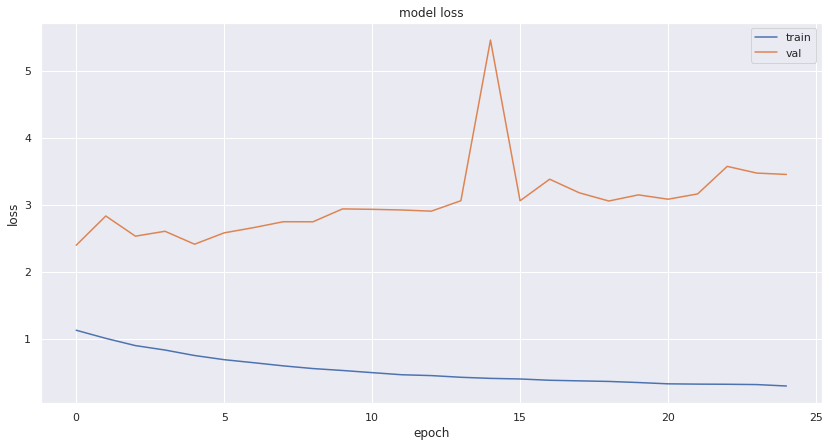

In [42]:
#Loss Plot

sns.set(rc={'figure.figsize':(14,7)})
plt.plot(modelTraining.history['loss'])
plt.plot(modelTraining.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

In [43]:
!cp -navr '/content/drive/My Drive/Colab Notebooks/IAM/Images/my-image (10).png' "/content/sample_data/IAM/Images/"

# Model Prediction

In [43]:
model_pred = Model(inputs=input_data, outputs=model_outputs)
model_pred.load_weights(filepath='HandWrittenTextPredictor.h5')

In [39]:
#model_pred.summary()

In [54]:
def decode_text(prediction):
    '''
    Input: Array of predicted sequence of indexes
    Output: Predicted Text
    '''
    classes = ' !"#&\'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
    prediction = prediction[prediction != -1]
    result = ''.join(list(map(lambda x: classes[int(float(x))], prediction)))
    return result

def predict(filename, my_model):
    '''
    Input: filepath of the image to be predicted
          Trained Model that should be used for prediction
    Output: Calls Decode function which inturn returns the resultant Text 
    '''
    #filepath='/content/sample_data/IAM/Images/'+filename
    sample_processed_image=[]
    sample_processed_image.append((preprocess_image(filename, 128, 64)).T)
    sample_processed_image=np.array(sample_processed_image)
    sample_processed_image = sample_processed_image.reshape(1, 128, 64, 1)
    prediction_trail = my_model.predict(x=sample_processed_image)
    prediction_decode = tf_keras_backend.get_value(tf_keras_backend.ctc_decode(prediction_trail,
                                                                                 input_length = np.ones(prediction_trail.shape[0])*prediction_trail.shape[1],
                                                                                  greedy=True)[0][0])
    
    return decode_text(prediction_decode)

In [44]:
filepath='predict_this.png'

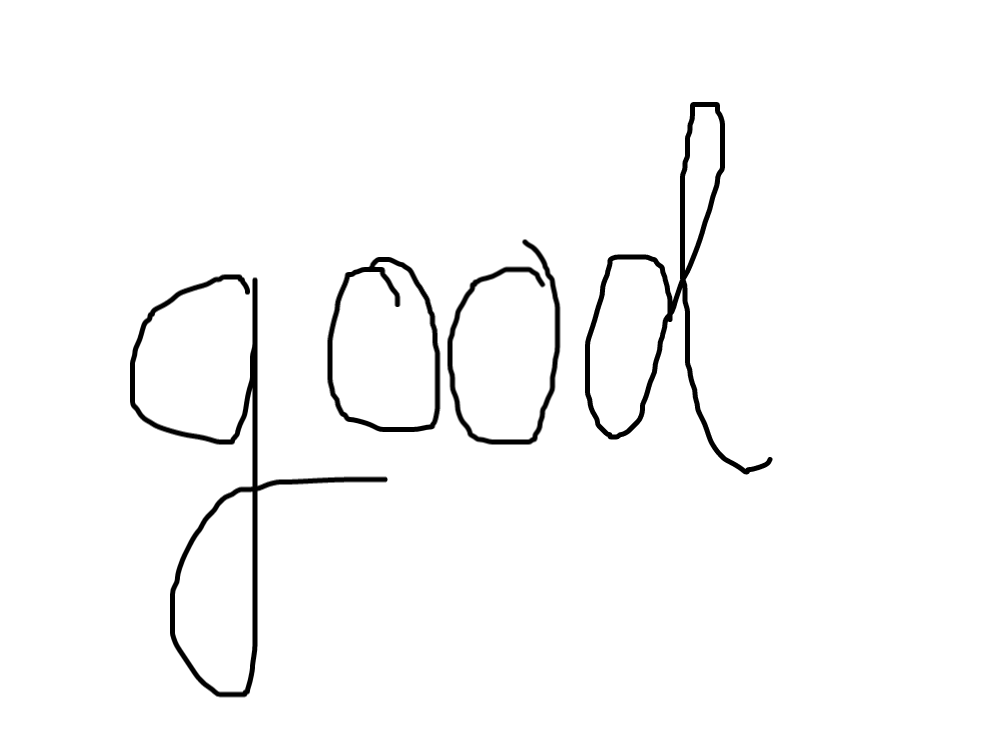

In [53]:
## Image that is drawn on the application
from PIL import Image
Image.open(filepath)

In [56]:
# Predicted Result
predict(filepath, model_pred)

good
